## Introduction
Since I upgraded my desktop and added a gtx 1070 graphics card, I have been having tons of fun training models in Tensorflow and XGBoost using my GPU and have been enjoying the multiple factors of speedup training time versus training on my CPU. On top of that, I have been enjoying gaming on my pc with the 1070 as well.

Anyway, in my last upload, I built a convolution neural network on the mnist dataset, which is a built-in dataset in Tensorflow and often used for benchmarking and considered the "Hello World!" of datasets in machine/deep learning. This time, I want to build a network on a dataset that isn't universally used as a benchmark dataset and a little more difficult to train on. I will be using the Dogs vs Cats dataset hosted on Kaggle for a competition for this notebook. 

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from scipy.misc import imshow, imresize
from skimage.io import imread
from skimage.transform import rotate, seam_carve, AffineTransform, warp, pyramid_reduce
from skimage.filters import gaussian
from skimage.util import random_noise, crop
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


** Data **

The dataset contains 25,000 total images of dogs and cats, 12,500 of each. The quality and size vary by image. For the sake of our model, the images will be resized to 64 by 64 pixels. The dataset will be split into 20,000 images for the training set, 2,500 for the validation set, and 2,500 for the testing set. Two images from the dataset are produced below. 

Size of image:  (410, 431, 3)


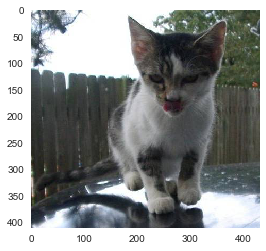

In [2]:
plt.grid(False)
img = imread('train/cats/cat.11.jpg')
print('Size of image: ', img.shape)
plt.imshow(img)

Size of image:  (371, 499, 3)


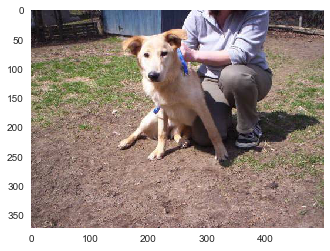

In [3]:
plt.grid(False)
img = imread('train/dogs/dog.22.jpg')
print('Size of image: ', img.shape)
plt.imshow(img)

To load the dataset, I will use a neat function in Keras that loads, rescales, resizes (64 x 64), and augments the images. This function is the ImageDataGenerator function in Keras and is a generator object in python when used. It generates images in batches indefinitely after performing the augmentations. Data augmentation is neccessary here because the relatively small amount of images in the dataset. 25,000 may sound like a lot of images, but for a neural network, it can easily be considered a small amount of data. For the data augmentation, each image will be randomly rotated, zoomed, sheared, and flipped horizontally so that the model has a small chance of seeing the same image more than once. This, in a sense, "produces" more samples for the model. 

In [31]:
size_img = 64
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, zoom_range = 0.2,
                                  shear_range = 0.2, horizontal_flip = True)
train_generator = train_datagen.flow_from_directory('train/', target_size = (size_img, size_img), 
                                                    classes = ['dogs', 'cats'], batch_size = 32)

Found 20000 images belonging to 2 classes.


In [32]:
valid_datagen = ImageDataGenerator(rescale = 1./255.)
valid_generator = valid_datagen.flow_from_directory('valid/', classes = ['dogs', 'cats'],
                                                    target_size = (size_img, size_img), batch_size = 200)

Found 2500 images belonging to 2 classes.


### Convolution Model

The structure of our convolution neural network model will be: 

[Convolution --> Convolution --> Max Pooling --> Convolution --> Convolution --> Max Pooling --> Fully Connected --> Fully Connected --> Output]

- The rectified linear unit function will be the activation function for each layer.
- There will be 32 3x3 filters for the first two convolution layers and then 64 3x3 filters with 1x1 stride used for each convolution layer after. 
- The max pooling layer will be 2x2 with stride 2. 
- Two full layers will be used with 512 neurons with a 50% dropout in between the full layers to avoid overfitting.
- The output layers will have two nodes, one for each class.
- Dogs will be labeled 1 and cats will be labled 0 for our model. 

- The cost function will be the cross entropy function:

$$
\displaystyle -\frac{1}{N} \sum_{i = 1}^{N} y_i \log\hat{y_i} + (1 - y_i)\log(1 - \hat{y_i})
$$

- ADAM with learning rate 0.0001 is used to optimize and find our model's parameters

After each epoch, 200 images from the validation set will sampled to test the accuracy and the status of our network. The average accuracy over each batch will also be recorded after each epoch on the training set to ensure we don't have overfitting issues. 

In [47]:
x = tf.placeholder(tf.float32, shape = [None, size_img, size_img, 3])
y = tf.placeholder(tf.float32, shape = [None, 2])

def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_var(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME' )

In [57]:
#Convolution
W_conv = weight_var([3, 3, 3, 32])
b_conv = bias_var([32])
h_conv = tf.nn.relu(conv2d(x, W_conv) + b_conv)

#Convolution
W_conv = weight_var([3, 3, 3, 32])
b_conv = bias_var([32])
h_conv = tf.nn.relu(conv2d(x, W_conv) + b_conv)

#Max Pooling
h_pool = max_pool(h_conv)

#Convolution
W_conv = weight_var([3, 3, 32, 64])
b_conv = bias_var([64])
h_conv = tf.nn.relu(conv2d(h_pool, W_conv) + b_conv)

#Convolution
W_conv = weight_var([3, 3, 64, 64])
b_conv = bias_var([64])
h_conv = tf.nn.relu(conv2d(h_conv, W_conv) + b_conv)

#Max Pooling
h_pool = max_pool(h_conv)


#Full Connected Layer
W_fc = weight_var([16 * 16 * 64, 512])
b_fc = bias_var([512])

h_pool_flat = tf.reshape(h_pool, [-1, 16 * 16 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc) + b_fc)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Full Layer
W_fc2 = weight_var([512, 2])
b_fc2 = bias_var([2])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


In [49]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_conv))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)
# train_step = tf.train.MomentumOptimizer(learning_rate = 0.0001, momentum = 0.9).minimize(cross_entropy)
correct_pred = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [50]:
# %%time
batch_size = 32
total_epoch = 100
loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(total_epoch):
    avg_cost = 0
    avg_train_accuracy = 0
    total_batch = 500
    for j in range(total_batch):
        x_train, y_train = next(train_generator)
        train_step.run(feed_dict = {x: x_train, y: y_train, keep_prob: 0.5})
        cost = cross_entropy.eval(feed_dict = {x: x_train, y: y_train, keep_prob: 1.0})
        train_accuracy = acc.eval(feed_dict = {x: x_train, y:y_train, keep_prob: 1.0})
        avg_train_accuracy += train_accuracy/total_batch
        avg_cost += cost/total_batch
    x_valid, y_valid = next(valid_generator)
    valid_accuracy = acc.eval(feed_dict = {x: x_valid, y: y_valid, keep_prob: 1.0})  
    loss_list.append(avg_cost)
    train_acc_list.append(avg_train_accuracy)
    valid_acc_list.append(valid_accuracy)
    print('Epoch: {}, Average Cost: {}, Train Accuracy: {} Validation Accuracy {}'.format(epoch + 1, 
                                                                                          avg_cost,
                                                                                          avg_train_accuracy, 
                                                                                         valid_accuracy))    

Epoch: 1, Average Cost: 0.85271017730236, Train Accuracy: 0.5948749999999993 Validation Accuracy 0.5899999737739563
Epoch: 2, Average Cost: 0.6332333377003672, Train Accuracy: 0.6315000000000001 Validation Accuracy 0.6149999499320984
Epoch: 3, Average Cost: 0.596719336628914, Train Accuracy: 0.6728749999999994 Validation Accuracy 0.7250000238418579
Epoch: 4, Average Cost: 0.5693885470032695, Train Accuracy: 0.6980624999999994 Validation Accuracy 0.7100000381469727
Epoch: 5, Average Cost: 0.5617966644763949, Train Accuracy: 0.7024374999999987 Validation Accuracy 0.6800000071525574
Epoch: 6, Average Cost: 0.5411041769981385, Train Accuracy: 0.725062499999999 Validation Accuracy 0.7699999809265137
Epoch: 7, Average Cost: 0.5258492806553837, Train Accuracy: 0.7333749999999983 Validation Accuracy 0.7750000357627869
Epoch: 8, Average Cost: 0.512374845087528, Train Accuracy: 0.744187499999998 Validation Accuracy 0.7699999809265137
Epoch: 9, Average Cost: 0.5013407156467442, Train Accuracy: 0.

With 100 epochs, our model was able to get descent accuracy on the validation set with a high of 93% accuracy. The cost decreases as the number of epochs increase so that is a good sign that our model is learning. In fact, the cost is decreasing well, even at the 100th epoch. We could actually use more epochs to further train the model. I will revisit this model and further train the model using more epochs. The training actually took a while to do with 100 epochs because I have a single graphics card. There are some things that I can do to speed up the training process that I want to experiment with. The first thing I want to try is to use the QueueRunner in Tensorflow. As of right now, I am using feed_dict to feed the data into the model. However, this uses python variables which can slow down the process of loading the data into the model.

### Results
Now, let's see how our trained network performs on the test set.

In [54]:
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = valid_datagen.flow_from_directory('test/', classes = ['dogs', 'cats'],
                                                    target_size = (size_img, size_img), batch_size = 50)

Found 2500 images belonging to 2 classes.


In [55]:
test_accuracy = 0
for i in range(50):
    x_test, y_test = next(test_generator)
    test_accuracy += acc.eval(feed_dict = {x: x_test, y: y_test, keep_prob: 1.0})
print('Test Accuracy: ', test_accuracy/50 * 100)

Test Accuracy:  89.9599995613


The accuracy for our network on the test set is 89.95%. Below is the plot of the behaviors of our network, the cost, training accuracy, and validation accuracy over epochs. The plot exhibits characteristics that we want our model to show: the loss/costs goes down over the number of epochs, and the training and validation accuracy goes up over the number of epochs. One thing that may be odd at first glance is the fluctuating behavior of the validation accuracy. The fluctuation is not too alarming since the validation accuracy is only on a small sample of 200 images, not the entire set after each epoch. 

(array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Text yticklabel objects>)

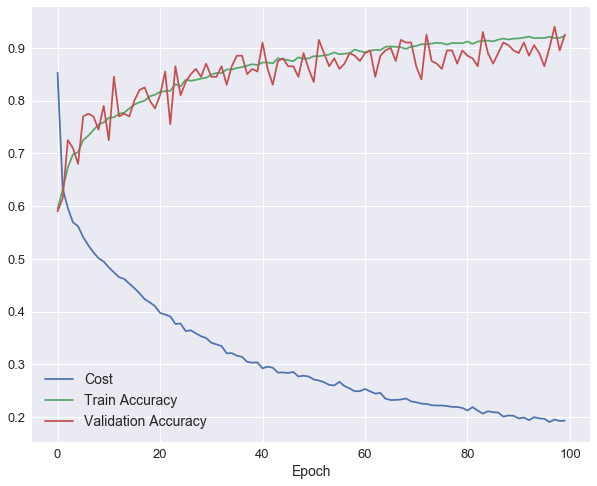

In [56]:
plt.figure(figsize = (10, 8))
plt.figure(1)
epochs = list(range(len(loss_list)))
plt.plot(epochs, loss_list, label = 'Cost')
plt.plot(epochs, train_acc_list, label = 'Train Accuracy')
plt.plot(epochs, valid_acc_list, label = 'Validation Accuracy')
plt.legend(fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

89.95% accuracy is decent, but by no means, state of the art. If we submit this exact model to the competition, we would be #74 on the leaderboard out of 215 teams. However, if we were actually competing, we could just use pretrained models and then add or tune the models to get better accuracy.

### Improvements

Our network can defintely be improved. Some things that can be done to get better accuracy are:

- Construct a deeper network using more convolution and pooling layers
- Use more augmentation on the data
    - horizontally and vertically shift the image, add random noise, ZCA whitening
- Higher dropout rate or/and add l-1, l-2 regularization
- Tune hyperparameters like learning rate, momentum, decay rate
- Use other optimizers 
    - Stochastic Gradient Descent
    - RMSProp
    
Remark: I actually did try other learning rates using ADAM and most of the learning rates I used seem to have gotten stuck at local optimas and the loss stopped decreasing after the first few epochs. 

I am actually mulling over the idea of getting another 1070 card for SLI to use multiple gpu training. This will speed up the training process marginally, if done correctly. As of right now, using a single gpu is a little more time consuming that I would like.  